# 1. Libraries and Data
In this first section I import the data into the work space, and give it the necessary format to be used during the stochastic modeling process.

In [2]:
# Libraries
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import matplotlib as mlp
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import os
import datatable as dt
from statsmodels.tsa.api import VAR
# import pmdarima as pm
%load_ext autoreload
%autoreload 2
import stochastic_modeling as stc

mlp.style.use('seaborn-notebook')
sns.set(font_scale=1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IndentationError: expected an indented block (stochastic_modeling.py, line 1073)

In [24]:
full_rates = dt.fread('historico_tasas_python.csv').to_pandas().drop(
    columns = 'C0').set_index('Fecha', drop=True)
full_rates.tail()

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,DTF,IPC Anual,IPC Mensual,FED,UVR,...,IBC,USURA,TRM,DEV. TRM,LIBOR,SOFR,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-11-07,0.025,0.02451,0.02463,0.02875,0.03640,0.0238,0.0458,0.0001,0.0025,287.5667,...,0.1727,0.25905,3881.76,0.038406,0.002209,0.0005,24.2717,-0.008347,643.51,0.045542
2021-11-08,0.025,0.02450,0.02459,0.02799,0.03515,0.0244,0.0458,0.0001,0.0025,287.6019,...,0.1727,0.25905,3881.76,0.038406,0.002190,0.0005,24.2707,-0.008388,643.51,0.045542
2021-11-09,0.025,0.02448,0.02458,0.02778,0.03500,0.0244,0.0458,0.0001,0.0025,287.6371,...,0.1727,0.25905,3874.41,0.036440,0.002151,0.0005,24.2700,-0.008700,644.05,0.046419
2021-11-10,0.025,0.02457,0.02478,0.02800,0.03431,0.0244,0.0458,0.0001,0.0025,287.6722,...,0.1727,0.25905,3876.86,0.063275,0.002195,0.0005,24.2691,-0.008834,644.96,0.046317
2021-11-11,0.025,0.02457,0.02478,0.02800,0.03431,0.0244,0.0458,0.0001,0.0025,287.7074,...,0.1727,0.25905,3875.38,0.061603,0.002195,0.0005,24.2692,-0.008376,644.95,0.046012


In [25]:
monthly_rates = full_rates.groupby(pd.Grouper(freq='M')).last()

In [26]:
def jump_class(x):
    if x>=5: return 5
    elif x==0: return 1
    else: return x
tibr = full_rates.loc['2000-01-01':,'TIBR']
saltos_tibr = tibr.loc[tibr/tibr.shift(1)!=1].to_frame().reset_index()
dc = saltos_tibr['Fecha']
shift_dc = dc.shift(1)
saltos_tibr['delta_t'] = 12*(dc.dt.year-shift_dc.dt.year)+dc.dt.month-\
    shift_dc.dt.month
saltos_tibr = saltos_tibr.loc[saltos_tibr['Fecha']>='2011-01-01']
saltos_tibr['clase'] = np.vectorize(jump_class)(saltos_tibr['delta_t'].values)
lmbda = saltos_tibr['clase'].mean()

In [27]:
saltos_tibr.head(3)

,Fecha,TIBR,delta_t,clase
45,2011-02-28,0.0325,9.0,5
46,2011-03-22,0.0350,1.0,1
47,2011-05-02,0.0375,2.0,2


In [28]:
saltos_tibr['clase'].mean()

1.9056603773584906

<AxesSubplot:xlabel='Fecha'>

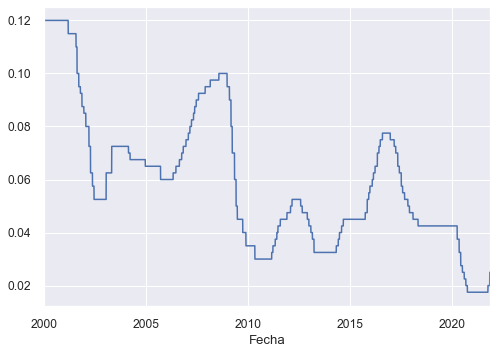

In [29]:
tibr.plot()

In [30]:
transformed = -np.log(0.15/saltos_tibr['TIBR']-1)
model = ARIMA(transformed.values, order=(4,0,4))
model_fit = model.fit()
model_fit.summary()

C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(4, 0, 4)   Log Likelihood                  65.936
Date:                Thu, 09 Dec 2021   AIC                           -111.872
Time:                        15:24:25   BIC                            -92.169
Sample:                             0   HQIC                          -104.295
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9311      0.303     -3.068      0.002      -1.526      -0.336
ar.L1         -0.1325      0.230     -0.576      0.565      -0.583       0.318
ar.L2          0.7114      0.329      2.162      0.031       0.066       1.356
ar.L3          0.2478      0.266      0.930      0.352      -0.274       0.770
ar.L4         -0.0662      0.334     -0.198      0.843      -0.722       0.589
ma.L1          2.0753      0.293      7.079      0.000       1.501       2.650
ma.L2          2.3209      0.440      5.278      0.000       1.459       3.183
ma.L3          1.7758      0.402      4.418      0.000       0.988       2.564
ma.L4          0.7851      0.223      3.515      0.000       0.347       1.223
sigma2         0.0042      0.001      3.601      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.97   Prob(JB):                         0.31
Heteroskedasticity (H):               1.56   Skew:                             0.26
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
adfuller(transformed)

(-2.72915200848259,
 0.06912811597814457,
 9,
 43,
 {'1%': -3.5925042342183704,
  '5%': -2.931549768951162,
  '10%': -2.60406594375338},
 -95.09906664657046)

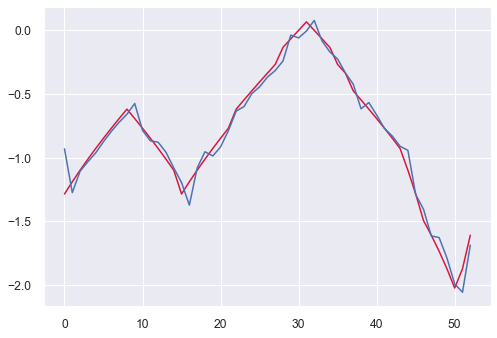

In [32]:
plt.plot(transformed.values, color='crimson')
plt.plot(model_fit.fittedvalues)

In [33]:
from sklearn.metrics import r2_score
r2_score(transformed.values, model_fit.fittedvalues)

0.9739019609416947

In [34]:
model_fit.resid.std()

0.08185864407809537

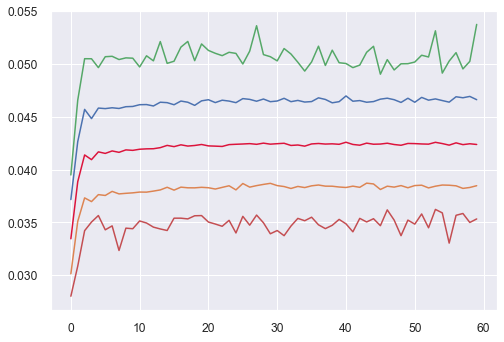

In [35]:
result = (model_fit.forecast(60)).reshape(60,1)+np.random.normal(
    scale = model_fit.resid.std()*np.sqrt(1),
    size = (60, 1000))
result = 0.15/(1+np.exp(-result))
mean = result.mean(axis=1)
mx = result.max(axis=1)
mn = result.min(axis=1)
ps = np.percentile(result, (5, 95), axis=1)
plt.plot(ps[1])
plt.plot(ps[0])
plt.plot(mean, color='crimson')
plt.plot(mx)
plt.plot(mn)

In [36]:
tibr_m = monthly_rates.loc['2008-01-01':, 'TIBR']
poisson = stc.PoissonRateSeries(tibr_m['2008-01-01':], p=2)
poisson.get_full_df()

Lambda value = 2.07


C:\Users\Teletrabajo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2008-01-31,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,...,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950,0.0950
2008-02-29,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-03-31,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-04-30,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
2008-05-31,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,...,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975,0.0975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-07-31,0.0425,0.0525,0.0425,0.0450,0.0475,0.0425,0.0425,0.0425,0.0475,0.0400,...,0.0450,0.0450,0.0425,0.0425,0.0375,0.0400,0.0425,0.0425,0.0400,0.0425
2026-08-31,0.0425,0.0525,0.0400,0.0450,0.0475,0.0400,0.0425,0.0425,0.0475,0.0400,...,0.0375,0.0450,0.0425,0.0400,0.0375,0.0400,0.0425,0.0425,0.0400,0.0425
2026-09-30,0.0425,0.0525,0.0400,0.0450,0.0475,0.0400,0.0425,0.0425,0.0425,0.0400,...,0.0375,0.0425,0.0425,0.0400,0.0375,0.0400,0.0425,0.0425,0.0400,0.0425
2026-10-31,0.0475,0.0450,0.0400,0.0425,0.0475,0.0375,0.0425,0.0425,0.0425,0.0400,...,0.0375,0.0425,0.0425,0.0400,0.0425,0.0400,0.0425,0.0425,0.0400,0.0450


(<Figure size 1080x504 with 1 Axes>, <AxesSubplot:>)

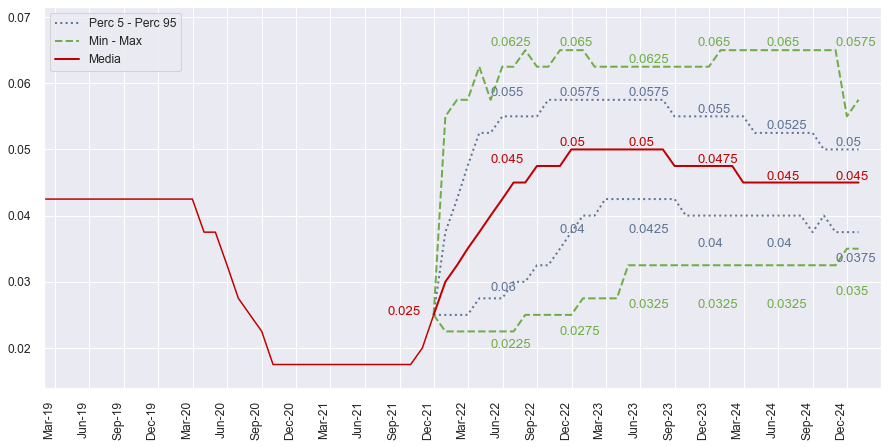

In [37]:
poisson.plot_full_series('2019-01-01','2024-12-31',dec=4, figsize=(15,7))

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

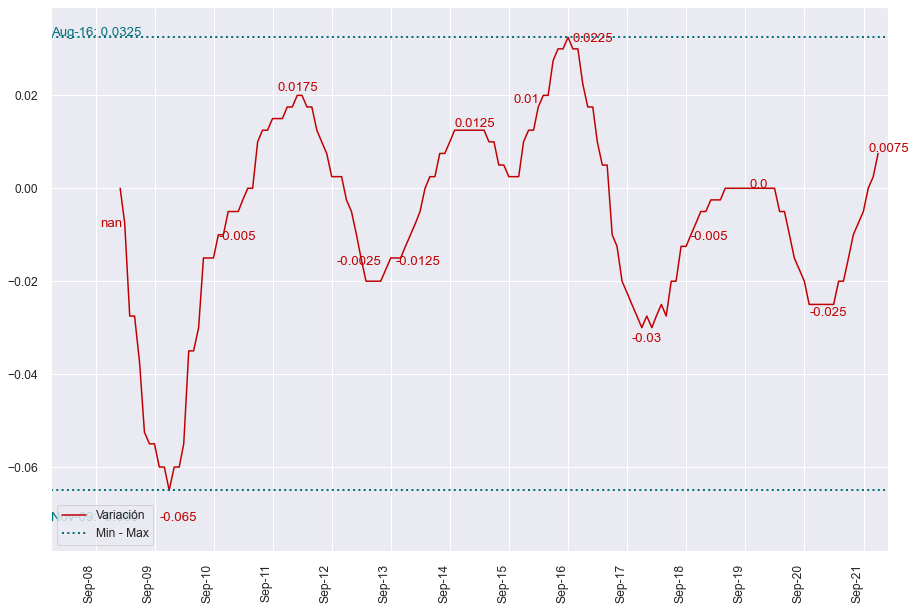

In [39]:
poisson.plot_historic_variation(ref=12, dec=4)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

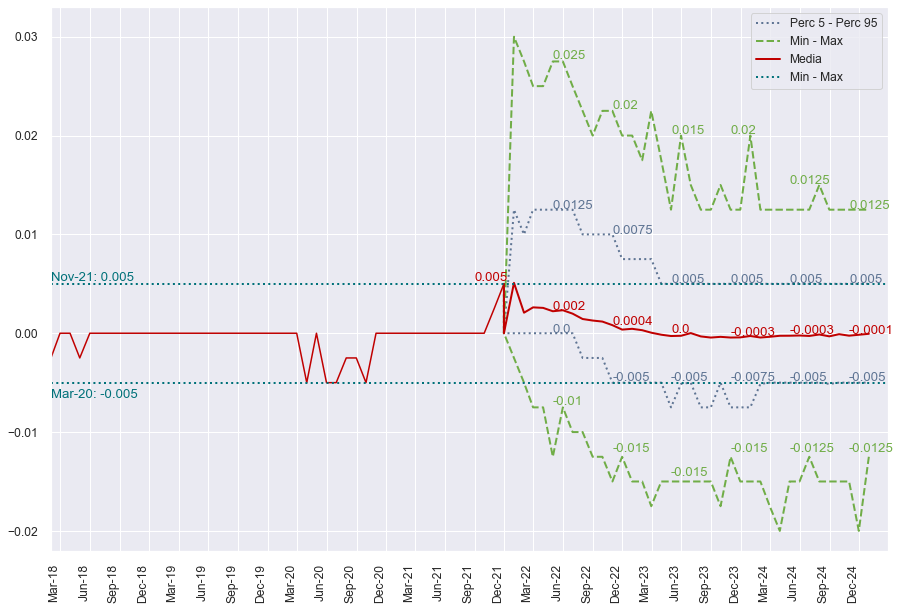

In [40]:
poisson.plot_full_variations('2018-01-01','2024-12-31', dec=4)

In [41]:
trm = monthly_rates['TRM']
trm_gbm = stc.GBMRateSeries(trm,Np=10000, Nt=60, T=60, u_bound=9000)

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

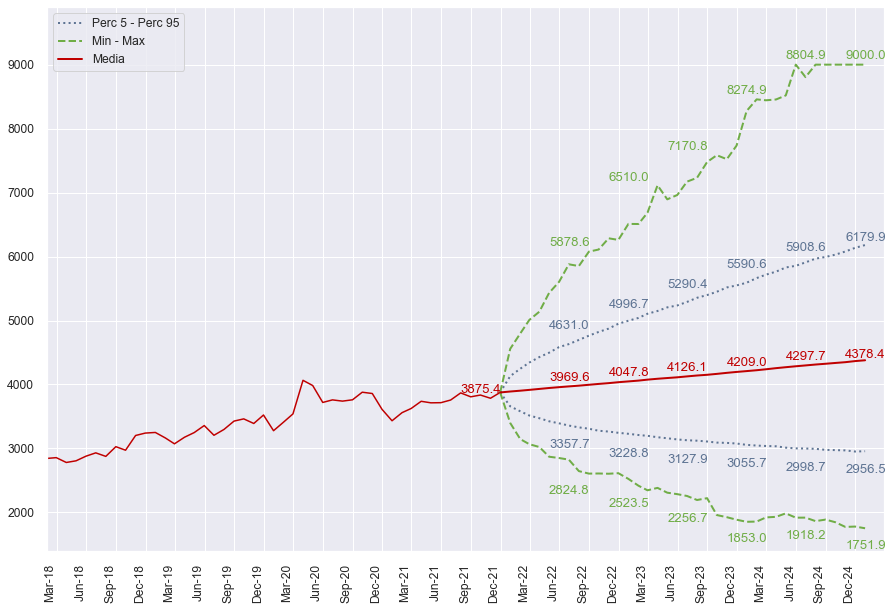

In [42]:
trm_gbm.plot_full_series('2018-01-01','2024-12-31')

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

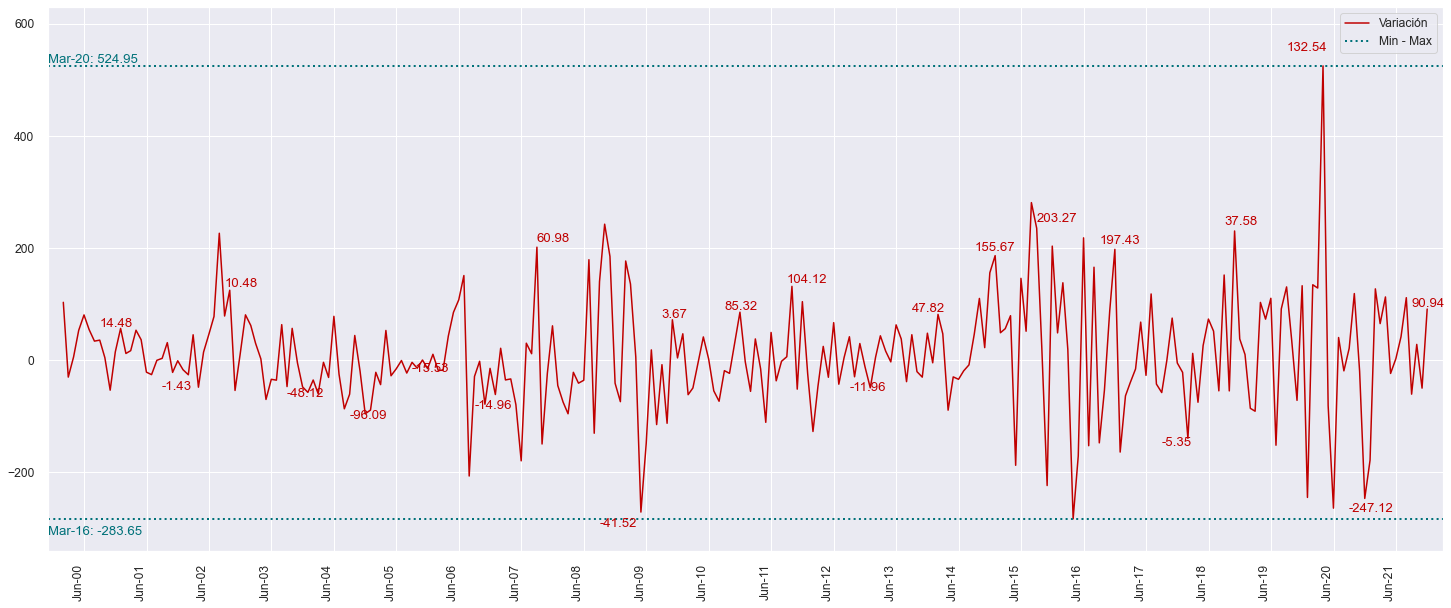

In [43]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10))

(<Figure size 1800x720 with 1 Axes>, <AxesSubplot:>)

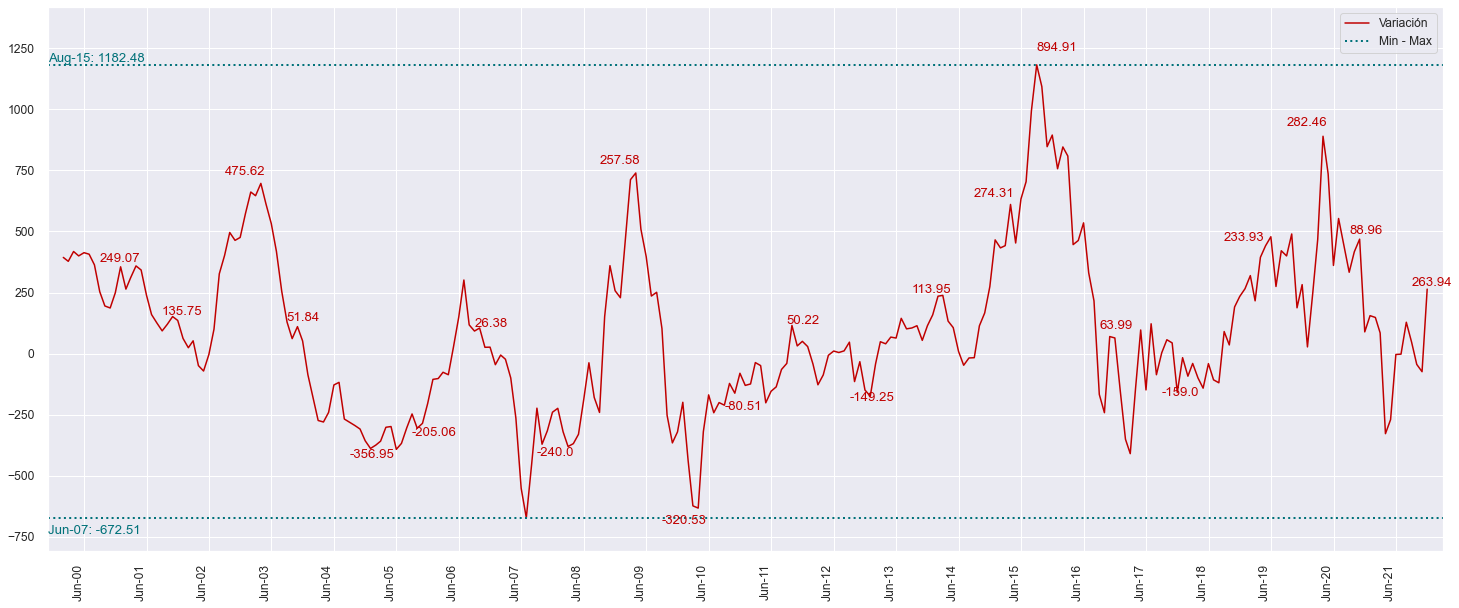

In [44]:
trm_gbm.plot_historic_variation(month_space=3, figsize=(25,10), ref=12)

(<Figure size 1440x720 with 1 Axes>, <AxesSubplot:>)

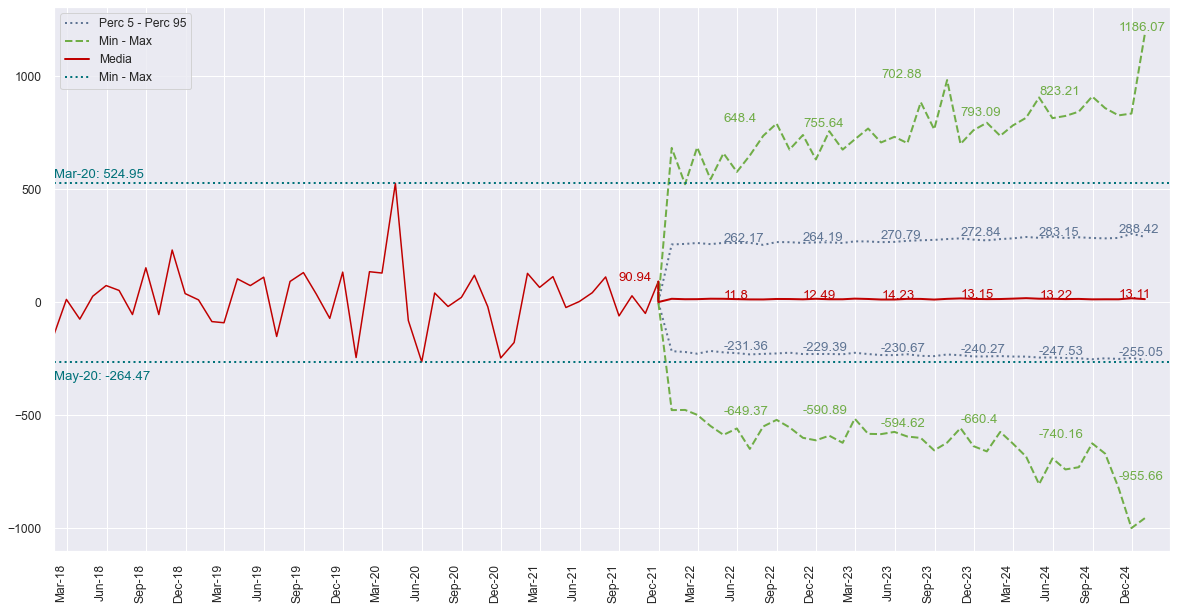

In [45]:
trm_gbm.plot_full_variations('2018-01-01', '2024-12-31', figsize=(20,10), dec=2)

In [63]:
# VAR Models
m = np.array([0.15, 1])
tibr_dtf = monthly_rates[['TIBR', 'IPC Anual']]
transformed_series = -np.log(m/tibr_dtf-1).dropna()['2008':]
model = VAR(transformed_series)
model_fit = model.fit(maxlags=2)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Dec, 2021
Time:                     15:44:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.71854
Nobs:                     165.000    HQIC:                  -9.83037
Log likelihood:           359.060    FPE:                4.98376e-05
AIC:                     -9.90678    Det(Omega_mle):     4.69491e-05
--------------------------------------------------------------------
Results for equation TIBR
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.112660         0.079026            1.426           0.154
L1.TIBR              1.200338         0.078516           15.288           0.000
L1.IPC Anual         0.248047         0.073992            3.352  

In [64]:
model_fit.

array([[[ 1.20033772,  0.24804679],
        [ 0.19691467,  1.4175554 ]],

       [[-0.25002004, -0.19837876],
        [-0.17611175, -0.48061058]]])

In [65]:
import typing

In [68]:
typing.Union[list, None]

typing.Union[list, NoneType]

In [4]:
l = ['a', 'b']
any(['a'==i for i in l])

True

In [5]:
if None:
    print('a')